## [Part 3](https://habrahabr.ru/post/236769/) (aslo see [how to markdown](http://assemble.io/docs/Cheatsheet-Markdown.html))

In [24]:
#install.packages("lubridate")
library("lubridate")
#Упрощает работу с датами
#install.packages("e1071")
library("e1071")
#Дает доступ к алгоритму наивного байесовского классификатора
#install.packages("quantmod")
library("quantmod")
#Позволяет импортировать необходимые данные и рассчитывать технические индикаторы
#install.packages("rpart") 
library("rpart")
#Даёт доступ к деревам решений, которые мы будем использовать.
#install.packages("rpart.plot") 
library("rpart.plot")
#Позволяет легко создать симпатичные диаграммы деревьев
#install.packages('FSelector') # the library for the hill climbing search
library(FSelector)
#install.packages('ggplot2') # the library for our plots
library(ggplot2)

Затем, давайте получим данные и рассчитаем индикаторы.

|Input	|Техническое имя	|Индикатор технического анализа|
|--|--|--|
|I01	|EMA5Cross	|Пересечение EMA5 и цены открытия
|I02	|EMA17Cross	|Пересечение EMA17 и цены открытия
|I03	|EMA5_17Cross	|Пересечение EMA17 и EMA5
|I04	|VolumeROC1	|Rate of Change / Momentum
|I05	|CCI12	|Commodity Channel Index 12
|I06	|MFI14	|Money Flow Index 14
|I07	|MOM	|Momentum 3 / Rate of Change
|I08	|Lag1	|Движение цены на текущем баре (1)
|I09	|Lag2	|Движение цены на текущем баре (2)
|I10	|Lag3	|Движение цены на текущем баре (3)
|I11	|Lag4	|Движение цены на текущем баре (4)
|I12	|Lag5	|Движение цены на текущем баре (5)
|I13	|fastK	|Stochastic Fast %K
|I14	|fastD	|Stochastic Fast %D
|I15	|slowD	|Stochastic Slow %D
|I16	|stochWPR	|William's %R
|I17	|RSI14	|Relative Strength Index (open) 14
|I18	|williamsAD	|Williams Accumulation / Distribution
|I19	|WPR	|William's %R 14
|I20	|AO	|(Awesome Oscillator, AO) SMA5 — SMA34
|I21	|AC	|AO сглаженный 5-периодной средней AO — SMA(AO, 5)
|I22	|MACD	|EMA12 — EMA26
|I23	|MACD_SMA9	|MACD сглаженный 9-периодной скользящей MACD- SMA(MACD, 9)
|I24	|DIp	|The positive Direction Index
|I25	|DIn	|The negative Direction Index.
|I26	|DX	|The Direction Index
|I27	|ADX	|The Average Direction Index (trend strength)
|I28	|ar	|aroon(HL, n) — 1 out (oscillator)
|I29	|chv16	|Chaikin Volatility — chaikinVolatility (HLC,n) — 1 out
|I30	|cmo16	|Chande Momentum Oscillator — CMO(Med, n) — 1 out
|I31	|macd12_26	|MACD Oscillator 12, 26, 9
|I32	|osma	|Moving Average of Oscillator
|I33	|rsi16	|Relative Strength Index med 16
|I34	|fastK14_3_3	|Stochastic Oscillator 14 3 3 fastK
|I35	|fastD14_3_3	|Stochastic Oscillator 14 3 3 fastD
|I36	|slowD14_3_3	|Stochastic Oscillator 14 3 3 slowD
|I37	|smi13_2SMI	|Stochastic Momentum Index SMI 13 2
|I38	|smi13_2signal	|Stochastic Momentum Index signal 13 2
|I39	|vol16	|Volatility 16
|I40	|SMA24Cross	|Логарифм отношения цены открытия и SMA24
|I41	|SMA60Cross	|Логарифм отношения цены открытия и SMA60
|I42	|SMA24_60Cross	|Логарифм отношения SMA24 и SMA60
|I43	|SMA24Trand	|Логарифм отношения SMA24 по сравнению с предыдущим значением
|I44	|SMA60Trand	|Логарифм отношения SMA24 по сравнению с предыдущим значением
|I45	|MOM24	|Momentum 24 / Rate of Change
|I46	|MOM60	|Momentum 60 / Rate of Change
|PCA	|PC1-PC16	|Сжатие признаков I01-I46 методом главных компонент в 16 значений

see [quantmod](https://cran.r-project.org/web/packages/quantmod/quantmod.pdf) and [TTR](https://cran.r-project.org/web/packages/TTR/TTR.pdf) for details; it will also useful to read [forecast](https://cran.r-project.org/web/packages/forecast/forecast.pdf) docs

In [25]:
startDate = as.Date("2007-01-01")
#Начало рассматриваемого промежутка

endDate = as.Date("2017-12-31") 
#Конец промежутка

getSymbols("FXPO.L", src = "google", from = startDate, to = endDate) 
#Получаем данные стоимости акций Bank of America

FXPO.L <- na.omit(FXPO.L)

[1] "FXPO.L"

In [26]:
len <- length(FXPO.L[,1])

## Beginning of [Part 2](https://habrahabr.ru/post/234303/)

Теперь, когда у нас есть все необходимые данные, давайте получим наш индикатор «день недели»:

In [27]:
DayofWeek<-wday(FXPO.L, label=TRUE)
#Находим день недели

То, что мы собираемся спрогнозировать, т.е. движение цены вверх или вниз, и создание финального набора данных:

In [28]:
PriceChange<- Cl(FXPO.L) - Op(FXPO.L)
#Находим разницу между ценой закрытия и ценой открытия.

Class<-ifelse(PriceChange>0, "UP","DOWN")
#Конвертируем в двоичную классификацию. (В наших данных не встречаются дни, когда цена открытия была равна цене закрытия, т. е. изменение было равно нулю, поэтому для упрощения мы не рассматриваем этот случай)

DataSet<-data.frame(DayofWeek,Class)
#Создаем наш набор данных

Теперь мы готовы применить наивный байесовский классификатор:

In [29]:
MyModel<-naiveBayes(DataSet[,1],DataSet[,2])
#Входное значение, или независимая переменная (DataSet[,1]), и то, что мы собираемся предсказывать, зависимая переменная (DataSet[,2]).

Улучшаем модель

Очевидно вам захочется использовать более сложную стратегию, нежели просто ориентирование на день недели. Давайте добавим пересечение со скользящей средней в нашу модель (вы можете получить больше информации о добавлении различных индикаторов к вашей модели здесь)
Я предпочитаю использовать экспоненциальные скользящие средние, поэтому давайте рассмотрим 5-ти дневные и 10-дневные экспоненциальные скользящие средние (EMA).
Для начала нам необходимо рассчитать EMA:

In [30]:
EMA5<-EMA(Op(FXPO.L),n = 5)
#Мы рассчитываем 5-периодную EMA по цене открытия

EMA10<-EMA(Op(FXPO.L),n = 10)
#Затем 10-ти периодную EMA, так же по цене открытия

Затем рассчитываем пересечение:

In [31]:
EMACross <- EMA5 - EMA10 
#Положительные значения будут означать что EMA5 расположена на графике выше EMA10

Теперь округляем значения до 2-х знаков после запятой. Это важно, поскольку если попадется значение, которое наивный классификатор байеса не видел во время обучения, он автоматически рассчитает вероятность в 0%. Например, если мы смотрим на пересечение EMA с точностью до 6-ти знаков, и была найдена высокая вероятность движения цены вниз, когда разница была \$2.349181, а затем была представлена новая точка данных, которая имела разницу \$2.349182, будет рассчитана 0% вероятность повышения или понижения цены. Окрулив до 2-х знаков после запятой, мы снижаем риск столкнуться с неизвестным для модели значением (при условии, что для обучения использовался достаточно большой набор данных, в котором скорее всего встретятся все значения индикатора). Это важное ограничение, о котором нужно помнить, при построении собственных моделей.

In [32]:
EMACross<-round(EMACross,2)

Давайте создадим новый dataset и разделим данные на тренировочный и тестовый набор. Таким образом, мы сможем понять, насколько хорошо работает наша модель на новых данных.

In [33]:
DataSet2<-data.frame(DayofWeek,EMACross, Class)
DataSet2<-DataSet2[-c(1:10),]
#Нам нужно удалить значения, в которых 10-периодная скользящая средняя все еще не рассчитана
TrainingSet<-DataSet2[1:328,]
#Мы используем 2/3 данных для обучения модели
TestSet<-DataSet2[329:492,] 
#И 1/3 для тестирования модели

Теперь построим модель:

In [34]:
EMACrossModel<-naiveBayes(TrainingSet[,1:2],TrainingSet[,3])

Условная вероятность пересечения скользящих средних – число, которое показывает среднее значение для каждого случая ([,1]) и для стандартного отклонения ([,2]). Мы можем видеть, что в среднем разница между 5-дневной EMA и 10-ти дневной EMА для длинных и коротких торгов была \$0.54 и -\$0.24 соответственно.
Теперь протестируем на новых данных:

In [35]:
acc<-table(predict(EMACrossModel,TestSet),TestSet[,3],dnn=list('predicted','actual'))

In [36]:
(acc[1,1]+acc[2,2])/(acc[1,1]+acc[1,2]+acc[2,1]+acc[2,2])

[1] 0.5304878

## End of Part 2

## Cont. of Part 3

In [37]:
RSI3<-RSI(Op(FXPO.L), n= 3) 
#Рассчитываем 3-х дневный индекс относительной силы (RSI) по цене открытия

EMA5<-EMA(Op(FXPO.L),n=5) 
#Рассчитываем 5-дневную экспоненциальную скользящую среднюю (EMA)
EMAcross<- Op(FXPO.L)-EMA5 
#Давайте посмотрим на разницу между ценой открытия и нашей 5-ти дневной EMA

SMAcross <- SMA(Op(FXPO.L),10)-EMA(Op(FXPO.L),30)

MACD<-MACD(Op(FXPO.L),fast = 12, slow = 26, signal = 9) 
#Рассчитываем MACD(Схождение/расхождение скользящих средних) со стандартными параметрами

MACDcross<-MACD[,1]-MACD[,2] 
#Используем только сигнальную линию в качестве индикатора 

SMI<-SMI(Op(FXPO.L),n=13,slow=25,fast=2,signal=9) 

#Стохастический осциллятор со стандартными параметрами
SMI<-SMI[,1] 
#Используем только осциллятор в качестве индикатора
SSTO <- stoch(HLC(FXPO.L))
Scross <- round(SSTO$fastD-SSTO$slowD,3)

Затем рассчитываем переменную, которую мы предсказываем и формируем data sets.

In [38]:
PriceChange<- Cl(FXPO.L) - Op(FXPO.L) 
#Рассчитываем разницу между ценой закрытия и открытия
Class<-ifelse(PriceChange>0,"UP","DOWN") 
#Переменная которую мы хотим предсказать.

DataSet<-data.frame(RSI3,EMAcross,MACDcross,SMI,Class,SSTO,Scross,SMAcross) 
#Создаем наш data set
colnames(DataSet)<-c("RSI3","EMAcross","MACDcross","Stochastic","Class",'SSTO','Scross','SMAcross') 
#Задаем имена колонкам
#DataSet<-DataSet[-c(1:33),] 
#Избавляемся от данных, на которых происходит первоначальное формирование индикаторов

train <- len/3*2
TrainingSet<-DataSet[1:train,] 
#Используем 2/3 наших данных для построения дерева
TestSet<-DataSet[train:len,]
#И оставляем 1/3 данных для тестирования нашей стратегии

Теперь, когда у нас есть всё, что нужно, давайте построим уже это дерево!

In [39]:
DecisionTree<-rpart(Class~RSI3+EMAcross+MACDcross+Stochastic+SSTO+Scross+SMAcross,data=TrainingSet, cp=.001)
#Указываем индикаторы, которые мы хотим использовать для предсказания и контролируем рост дерева, указывая минимальное значение параметра сложности (ср), необходимого для организации разделения.

Отлично! У нас есть наше первое дерево решений, посмотрим, что же мы построили.

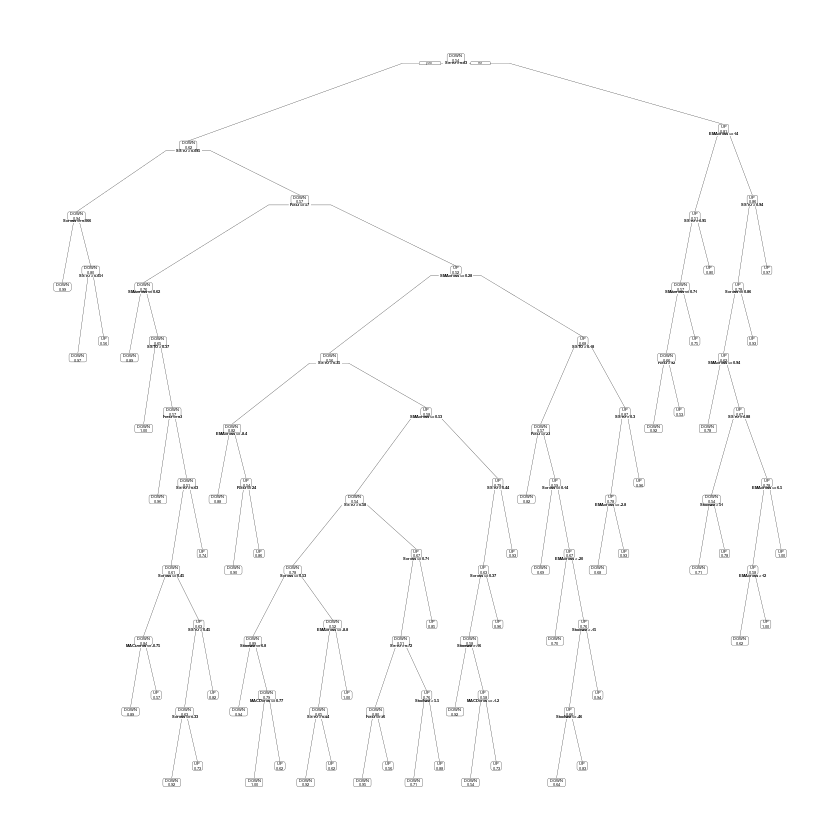

In [40]:
prp(DecisionTree,type=2,extra=8)
#Отличный графический инструмент, с несколькими параметрами для красивого отображения. 

Маленькая заметка по интерпретации этого дерева: узлы представляют расщепление, где левая ветка отражает ответ «да», а правая ветка ответ «нет». Число в конечном листе – процентное число случаев, которые были корректно классифицированы этим узлом. 
Дерева решений так же могут быть использованы для выбора и оценки индикаторов. Индикаторы, которые ближе к корню (верх) дерева, дают больше разделений и содержат больше информации чем те, что внизу дерева. В нашем случае Стохастический Осциллятор даже не попал в дерево!

Хоть у нас и появился набор правил, которым можно следовать, стоит все-таки убедиться, что мы не переобучили модель, поэтому давайте подрежем дерево. Самый простой способ сделать это – посмотреть на параметр сложности, который является «стоимостью», или снижением производительности. Для этого нужно добавить еще одно разделение и выбрать размер дерева, который минимизирует нашу ошибку перекрестной проверки.


Classification tree:
rpart(formula = Class ~ RSI3 + EMAcross + MACDcross + Stochastic + 
    SSTO + Scross + SMAcross, data = TrainingSet, cp = 0.001)

Variables actually used in tree construction:
[1] EMAcross   MACDcross  RSI3       Scross     SMAcross   SSTO       Stochastic

Root node error: 815/1759 = 0.46333

n=1759 (3 observations deleted due to missingness)

          CP nsplit rel error  xerror     xstd
1  0.2638037      0   1.00000 1.00000 0.025661
2  0.0392638      1   0.73620 0.73988 0.024426
3  0.0361963      5   0.54969 0.64663 0.023573
4  0.0184049      7   0.47730 0.57791 0.022787
5  0.0159509      8   0.45890 0.55460 0.022486
6  0.0110429      9   0.44294 0.55337 0.022470
7  0.0073620     11   0.42086 0.52147 0.022028
8  0.0061350     18   0.35828 0.48221 0.021435
9  0.0049080     21   0.33988 0.48098 0.021416
10 0.0042945     22   0.33497 0.47730 0.021357
11 0.0036810     26   0.31779 0.46748 0.021198
12 0.0030675     31   0.29816 0.47117 0.021258
13 0.0020450     34

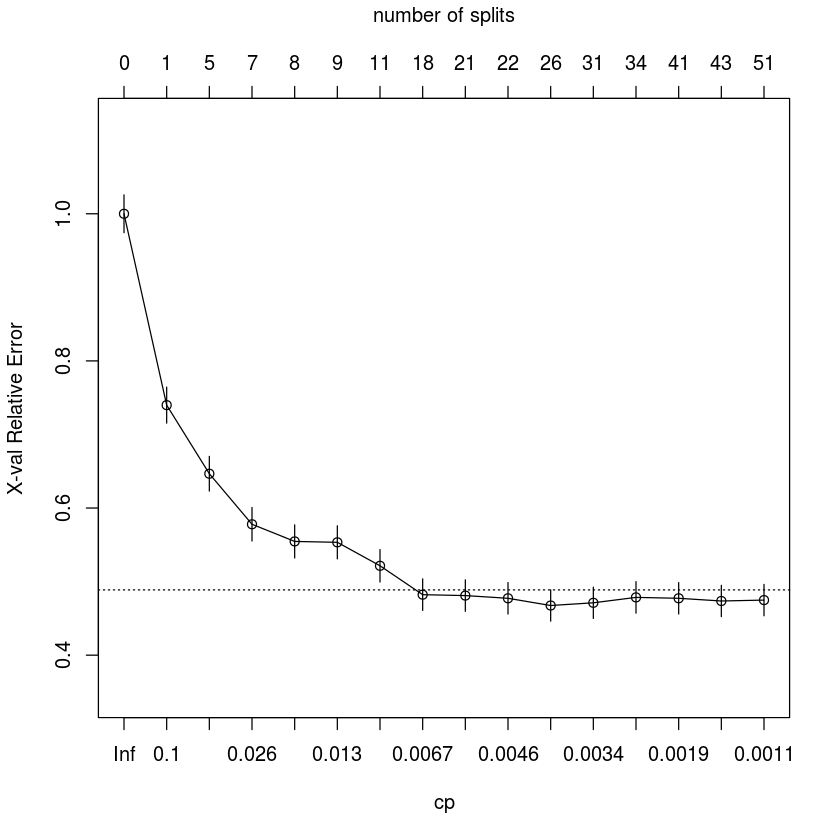

In [41]:
printcp(DecisionTree)
#Вывод минимального cp(параметра сложности) для каждого дерева, каждого размера
plotcp(DecisionTree,upper="splits")
#Чертеж среднего геометрического значения для деревьев каждого размера

In [42]:
minel <- printcp(DecisionTree)[match(min(printcp(DecisionTree,digits = 3)[,4]),printcp(DecisionTree,digits = 3)[,4]),1]


Classification tree:
rpart(formula = Class ~ RSI3 + EMAcross + MACDcross + Stochastic + 
    SSTO + Scross + SMAcross, data = TrainingSet, cp = 0.001)

Variables actually used in tree construction:
[1] EMAcross   MACDcross  RSI3       Scross     SMAcross   SSTO       Stochastic

Root node error: 815/1759 = 0.46333

n=1759 (3 observations deleted due to missingness)

          CP nsplit rel error  xerror     xstd
1  0.2638037      0   1.00000 1.00000 0.025661
2  0.0392638      1   0.73620 0.73988 0.024426
3  0.0361963      5   0.54969 0.64663 0.023573
4  0.0184049      7   0.47730 0.57791 0.022787
5  0.0159509      8   0.45890 0.55460 0.022486
6  0.0110429      9   0.44294 0.55337 0.022470
7  0.0073620     11   0.42086 0.52147 0.022028
8  0.0061350     18   0.35828 0.48221 0.021435
9  0.0049080     21   0.33988 0.48098 0.021416
10 0.0042945     22   0.33497 0.47730 0.021357
11 0.0036810     26   0.31779 0.46748 0.021198
12 0.0030675     31   0.29816 0.47117 0.021258
13 0.0020450     34

Вы можете видеть, что наименьшая ошибка достигается для дерева из XX разделений. Благодаря режиму перекрестной проверки, который случайным образом выбирает данные для тестирования модели, ваш результат может отличаться от того, который отображен на скриншоте. Один из недостатков дерева решений в том, что они могут быть не стабильными, т.е. малые изменения данных могут привести к большим изменениям в дереве. Поэтому процесс «обрезки» дерева и другие способы предотвратить переобучение столь важны.

Давайте обрежем это дерево и посмотрим, как будет выглядеть наша стратегия.

In [43]:

PrunedDecisionTree<-prune(DecisionTree,cp=minel)
#Я использую параметр сложности (cp), у которого наименьшая ошибка перекрестной проверки (xerror)
minel

[1] 0.003680982

Теперь дерево выглядит так:

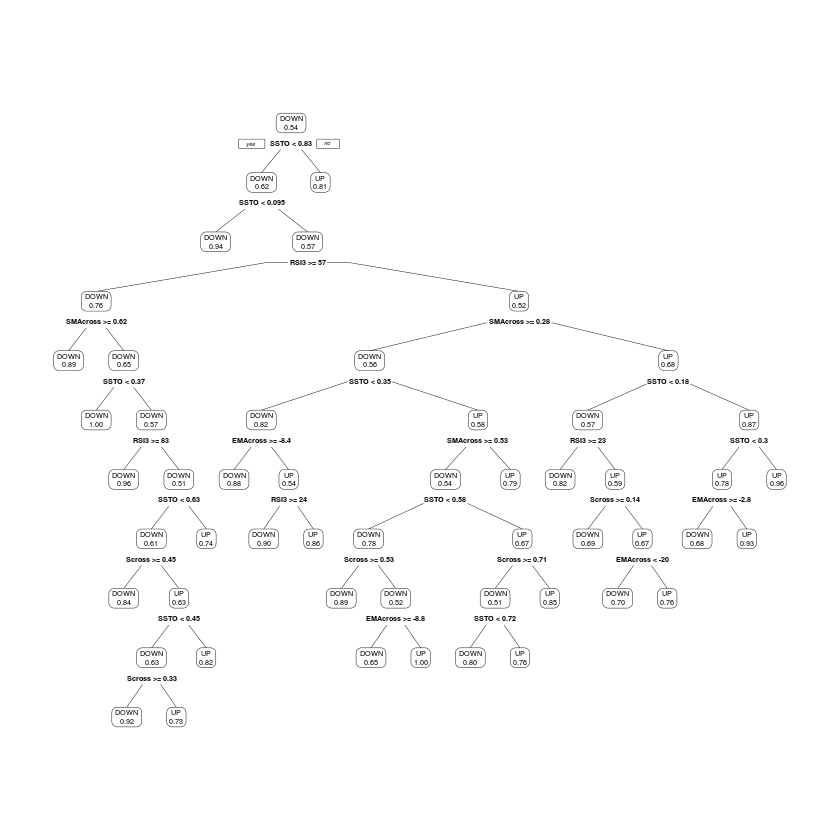

In [44]:
prp(PrunedDecisionTree, type=2, extra=8)

Так гораздо лучше! Здесь видно, что линия MACD сигнала больше не используется. Мы начали с 4-х индикаторов, из которых только 3-х дневный RSI, разница между ценами, и 5-ти дневный EMA могут быть полезны в предсказании движения цены.

Пришло время проверить модель на тестовых данных.

In [45]:
acc <- table(predict(PrunedDecisionTree,TestSet,type="class"),TestSet[,5],dnn=list('predicted','actual'))

In [46]:
(acc[1,1]+acc[2,2])/(acc[1,1]+acc[1,2]+acc[2,1]+acc[2,2])

[1] 0.7811791

In [47]:
getSymbols("FXPO.L", src = "google")
FXPO.L <- na.omit(FXPO.L)
RSI3<-RSI(Op(FXPO.L), n= 3) 
EMA5<-EMA(Op(FXPO.L),n=5) 
EMAcross<- Op(FXPO.L)-EMA5 
SMAcross <- SMA(Op(FXPO.L),10)-EMA(Op(FXPO.L),30)
MACD<-MACD(Op(FXPO.L),fast = 12, slow = 26, signal = 9) 
MACDcross<-MACD[,1]-MACD[,2] 
SMI<-SMI(Op(FXPO.L),n=13,slow=25,fast=2,signal=9) 
SMI<-SMI[,1] 
SSTO <- stoch(HLC(FXPO.L))
Scross <- round(SSTO$fastD-SSTO$slowD,3)
PriceChange<- Cl(FXPO.L) - Op(FXPO.L) 
Class<-ifelse(PriceChange>0,"UP","DOWN") 
DataSet<-data.frame(RSI3,EMAcross,MACDcross,SMI,Class,SSTO,Scross,SMAcross) 
colnames(DataSet)<-c("RSI3","EMAcross","MACDcross","Stochastic","Class",'SSTO','Scross','SMAcross')
tail(predict(PrunedDecisionTree,DataSet,type="class"))

[1] "FXPO.L"

2017-12-15 2017-12-18 2017-12-19 2017-12-20 2017-12-21 2017-12-22 
        UP         UP         UP         UP         UP         UP 
Levels: DOWN UP

В общем не плохо, XX% точность. Что более важно, у вас есть основа стратегии с четко определенными, математическими параметрами. Используя всего 25 команд, мы смогли определить, какие индикаторы полезны и какие специальные условия нам нужны для совершения сделки. Теперь вы можете использовать эти индикаторы для собственной торговли или улучшить дерево.

В следующей статье мы рассмотрим еще один мощный алгоритм машинного обучения, метод опорных векторов, и разберемся, как можно использовать его результаты для еще более здравой стратегии.

## How to Trade the RSI: An analysis using a Support Vector Machine (base on [this](https://inovancetech.com/how-to-trade-rsi.html))

Machine-learning algorithms can be used to find the best values to trade your indicators.

The Relative Strength Index, or RSI, is one of the most common technical indicators. It is used to identify oversold and overbought conditions. Traditionally, traders look for RSI values over 70 to represent overbought market conditions and under 30 to represent oversold market conditions. However, is there any validity to these claims? Why 70 and why 30? Further, how do different trending markets affect the RSI signals you should be looking for?

In this post, we’ll use a Support Vector Machine (SVM), a powerful machine-learning algorithm, to explore what values of an RSI you should actually be looking for while taking into account the overall trend in the market.

First, we’ll give a brief overview of the SVM, then outline the problem, and finally build and test a strategy based off of the patterns discovered by the algorithm.

### Support Vector Machines

Support Vector Machines are one of the more popular and powerful “off-the-shelf” machine-learning algorithms based on their ability to find non-linear patterns. SVMs work by finding a line, known as a “decision boundary” or “hyperplane”, that best separates your data based on the class (in our case, “bullish” or “bearish” bars). The power of an SVM is being able to rearrange, or map, your data with a set of mathematical functions, known as “kernels”, into a multidimensional feature space where your data is linearly separable.

The SVM then draws a line in the higher dimensional space that maximizes the distance between the two classes. When a new data point is presented to the SVM, it then calculates which side of the line the point falls and makes its prediction.

Another advantage of the SVM is there are relatively few parameters that must be selected before you are able to use it. First, you must select the kernel, or mapping, function to use to translate your data into a higher dimensional space. A radial basis function is a popular choice and will work well in our case. Next, you need to choose the gamma parameter. The gamma determines how much effect a single training example can have on the decision boundary. Low values mean a single point will have a large effect on where the line is drawn and high values mean each point will only have a small effect. A good rule of thumb to select the gamma parameter to be one over number of inputs to your model (1/(number of inputs)). Finally, you need to choose the regularization parameter, C. C determines the trade off between misclassifying examples in your training set and the simplicity of the decision boundary. A low C creates a smoother decision boundary and decreases overfitting, while a high C will attempt to classify every data point in the training set correctly and may lead to overfitting. We want to decrease how much our model overfits so we will select a value of 1 but feel free to play around with it yourself.

Now that we have a basic idea of how a Support Vector Machine works and how to select its parameters, let’s see if we can use it to figure out how to trade an RSI.

### Trading an RSI

The relative strength index, or RSI, compares the average size of the “up” moves to the average size of the “down” moves and normalizes it between 0 and 100. The conventional logic goes that once the asset has had more, significant upticks, it has become overbought, or overvalued, and is likely to decrease in price. Overbought is usually determined by an RSI value over 70, with opposite conditions representing oversold, or undervalued, at an RSI value of 30.

However, these conditions don’t happen in a vacuum. There are also broader market trends at work. An RSI value over 70 in the middle of a strong uptrend might represent a continuation of the trend while a value of 70 during a downtrend could signify a great entry point. The problem is finding out exactly what conditions we should be looking for considering both factors.

We could gather thousands of data points and try to find those relationships ourselves or we could use a Support Vector Machine, an algorithm designed to find non-linear patterns, to do the legwork for us.

Let’s see what patterns we are able to find in a 3-period RSI and define a trend by comparing the open price to a 50-period simple moving average (SMA) using the AUD/USD 4 hour charts.

### Building Your Model

Let’s use R to build our model, analyze the patterns it was able to find and then test to see if those patterns hold up in an actual trading strategy.

To create the data set and build the model (data can be downloaded from [here](https://www.dropbox.com/s/kk47ydcz36xik2i/AUDUSD.csv?dl=0), [e1071 package man](https://cran.r-project.org/web/packages/e1071/e1071.pdf) might be useful as well)

In [51]:
#getSymbols('FXPO.L') # Added by me
Data<-na.omit(FXPO.L)       # the same
#Our 4-hour bars of the Australian Dollar/US Dollar currency pair dating back to 01/01/2010. You can download it here (dropbox) for your own use.
RSI3<-RSI(Op(FXPO.L),n=3)
#The 3-period relative strength index calculated off the open
SMA50<-SMA(Op(FXPO.L),n=50)
Trend<-Op(FXPO.L)-SMA50
#Our measure of trend: the difference between the open price and the 50-period simple moving average
Price<-Cl(FXPO.L)-Op(FXPO.L)
Class<-ifelse(Price>0,"UP","DOWN")
#The variable we are looking to predict; the direction of the next bar
DataSet<-data.frame(RSI3,Trend,Class)
#DataSet<-DataSet[-c(1:49),]
colnames(DataSet) <-  c('RSI3','Trend','Class')
#Create the data set and removing the points where our indicators are still being calculated
Training<-DataSet[1:0.6*len,]
Test<-DataSet[0.6*len:0.8*len,]
Val<-DataSet[0.8*len:len,]
#Separate the data into 60% training set to build our model, 20% test set to test the patterns we found, and 20% validation set to run our strategy over new data
SVM<-svm(Class~RSI3+Trend,data=Training, kernel="radial",cost=1,gamma=1/2)
#Build our support vector machine using a radial basis function as our kernel, the cost, or C, at 1, and the gamma function at ½, or 1 over the number of inputs we are using
TrainingPredictions<-predict(SVM,Training,type="class")
#Run the algorithm once more over the training set to visualize the patterns it found
TrainingData<-data.frame(Training,TrainingPredictions)
#Create a data set with the predictions
ggplot(TrainingData,aes(x=Trend,y=RSI3))+stat_density2d(geom="contour",aes(color=TrainingPredictions))+labs(title="SVM RSI3 and Trend Predictions",x="Open - SMA50",y="RSI3",color="Training Predictions")
#Now let’s see what patterns it was able to find

ERROR: Error in if (any(co)) {: missing value where TRUE/FALSE needed


Interesting! We can see three distinct areas where the algorithm went short and one range in the middle where it only went long. Let’s explore further.

|Long	|Short
|--|--|
|RSI below 25 and the Price is more than 20 pips below the SMA 50 (56% accurate, 36 trades)	 |RSI less than 25 and the Price is between 10 and 5 pips below the SMA 50 (54% accurate, 81 trades)
|RSI3 is between 50 and 75 and the Price is between 5 and 10 pips above the SMA 50 (58% accurate, 104 trades )	 |RSI greater than 70 and the Price more than 5 pips below the SMA 50 (59% accurate, 37 trades)
||RSI greater than 75 and price more than 15 pips above the SMA 50 (59% accurate, 34 trades)

First the short area on the bottom left. Here the price has just crossed below the 50-period SMA and the RSI is below 25, suggesting a breakout of a downward trend.

However, if the price moves beyond 20 pips below the 50-period SMA and the RSI remains under 25, the algorithm found a stronger signal for a reversion to the mean and predicted a long trade.

Next, the short opportunity on the upper left of the plot represents the traditional view of the RSI. Here we are looking for the RSI to be over 70 while the price is more than 15 pips above the 50-period SMA to represent “overbought” conditions, suggesting we go short.

The short area on the upper left is a little different. When the price had just crossed below the 50-period SMA and the RSI was over 70, it found a short opportunity. This is similar to the first case but instead of traditional “overbought” conditions, we are looking for a bearish breakout entry signal.

Finally, there was an area where the RSI was between 50 and 75, while the price had crossed above the 50-period SMA where the algorithm found a strong buy signal.

Now that we have found a basic set of rules that the SVM uncovered, let’s test to see how well they hold up over new data, our test set.



In [ ]:
ShortRange1<-which(Test$RSI3 < 25 & Test$Trend > -.010 & Test$Trend < -.005)
ShortRange2<-which(Test$RSI3 > 70 & Test$Trend < -.005)
ShortRange3<-which(Test$RSI3 > 75 & Test$Trend > .015)
LongRange1<-which(Test$RSI3 < 25 & Test$Trend < -.02)
LongRange2<-which(Test$RSI3 > 50 & Test$RSI3 < 75 & Test$Trend > .005 & Test$Trend < .01)

Now let’s see how well these patterns hold up over out test set:

In [ ]:
ShortTrades<-Test[c(ShortRange1,ShortRange2,ShortRange3),]
ShortCorrect<-((length(which(ShortTrades[,3]=="DOWN")))/nrow(ShortTrades))*100
#Our short trades
LongTrades<-Test[c(LongRange1,LongRange2), ]
LongCorrect<-((length(which(LongTrades[,3]=="UP")))/nrow(LongTrades))*100
#Our long trades

Wow! 58% (85 correct out of 147 trades) for our short trades and 57% (80 correct out of 140 trades) for our long trades.

Now let’s turn this into an actual trading strategy with a stop loss and take profit as our exit conditions.

[Note: see my previous post “How to Backtest in R” for step-by-step instructions]

I added a fairly tight take profit and stop loss and maintained a 1:1 risk-to-reward ratio due to the short nature of our predictions (just one bar) and to take advantage of our over 50% accuracy.

Let’s see how well we did:

You can see how well the strategy did compared to the a buy-and-hold strategy and just the entry signals. Overall, the equity curve looks fairly smooth and a strategy based off these two simple indicators looks very promising.

Using a Support Vector Machine, a powerful machine-learning algorithm, we were not only able to learn under what conditions the conventional wisdom of an RSI hold up but we were able to create a robust trading strategy.

This process, known as Association Rule Learning, or deriving rules from machine-learning algorithms, allows you to leverage the capabilities of a machine-learning algorithm with your own experiences as a trader.

We believe that the best results are found when combining both man and machine, and this has formed the basis of TRAIDE. We are excited to announce that TRAIDE for FX is now available so sign up now for a free trial. We’d love to have your feedback!

## Time to work with [Part 4](https://inovancetech.com/machine-learning-feature-selection.html)

Selecting the indicators to use is one of the most important and difficult aspects of building a successful strategy.

Not only are there thousands of different indicators, but most indicators have numerous settings which amounts to virtually limitless indicator combinations. Clearly testing every combination is not possible, so many traders are left on their own selecting somewhat random inputs to build their strategy.

Luckily this process, known as “feature selection”, is a very well-researched topic in the machine learning world. In this post we’ll use a popular technique known as a “wrapper method” that uses a support vector machine (SVM) and a “hill climbing” search to find a robust subset of indicators to use in your strategy.

### Feature Selection with Machine Learning: Wrapper Method and Hill Climbing

Selecting from the near limitless possible combinations of indicators to use in your strategy can be very daunting. However, this is a problem that machine learning experts and data scientists have been grappling with for a long time and have come up with a wide range of tools and techniques to help you out.

One popular technique is a wrapper method. A wrapper method uses a machine-learning algorithm to evaluate each subset of indicators. The main advantage to this method, as opposed to evaluating each indicator on its own, is we can find the relationships and dependencies between indicators. For example, a 14-period RSI or a 30-period CCI alone may not be great predictors, but combined could provide some valuable insight.

The next question is how do you decide which subsets of indicators to evaluate? If you are only looking at a few indicators then trying every combination might be possible, but even looking through 15 different indicators for 3 to use in your strategy leads to over 450 different possible combinations! Other techniques either rank the indicators based on a certain performance metric, like correlation, or start with the full or empty set and add/subtract indicators one by one. These type of searches are known as being “greedy”, meaning that they can only search in one direction, e.g. going from strongest correlation to weakest, but may miss some important relationships between indicators.

One method that attempts to get around this is the known as a “hill climbing” method. A hill climbing method starts with a random subset of indicators and then evaluates all of the “neighboring” combinations, selecting the best performing combination. While this does allow us to find interesting relationships between indicators, there is a chance that we get stuck in what’s called a “local maximum,” which means that it may just be the best combination of neighbors but not necessarily the best overall combination. To get around this, we can run the search multiple times to see what patterns emerge in the top neighboring subsets.

For this article, we’ll use a support vector machine (which we previously used to [build a strategy for the RSI](https://inovancetech.com/how-to-trade-rsi.html)) and repeat the hill climbing search 10 times to find the best subset.

### Selecting Indicators

Even when using these techniques, we still need to define the feature space to search from. This is where your domain experience comes in. Now you may not know the best period to use, but you most likely have a set of “favorite” indicators that you know and make sense to you conceptually. You can give this process a huge head start by selecting meaningful, relevant indicators that you understand.

In the name of simplicity, we’ll start with just 5 different and commonly used base indicators: SMA, EMA, RSI, CCI and MACD.

We can use different periods and calculations based off these indicators to create features.

For example, here are 20 different "features":

|Indicator |Indicator|
|--|--|
|Price - SMA(5)	 |Price - SMA(30)|
|Price - SMA(50)	 |SMA(5) - SMA(30)|
|SMA(5) - SMA(50)	 |SMA(30) - SMA(50)|
|Price - EMA(5)	 |Price - EMA(30)|
|Price - EMA(50)	 |EMA(5) - EMA(30)|
|EMA(5) - EMA(50)	 |EMA(30) - EMA(50)|
|RSI(5)	 |RSI(14)|
|RSI(30)	 |CCI(5)|
|CCI(14)	 |CCI(30)|
|MACD_Line	 |MACD_Signal|

We can see how even looking at only 5 indicators leads to a huge number of possible inputs to your strategy!

Let's get started building our model. We'll explore the usefulness of the above 20 features in building a profitable strategy.

### Building Our Model

Now that we have our features we can build our model in R (When working with an SVM, it is important to normalize the data: You can [download](https://inovancetech.com/Data/audusd_model_data.zip) the original data and the normalized data we use for inputs to the model here).

First, we need to install the necessary libraries:

Then split the data into our training and test sets. We’ll use ⅔ of the data to build the model and reserve ⅓ to test out of sample.

In [52]:
Model_Data <- read.csv('AUDUSD_Model_Data_Normalized.csv')
Breakpoint <- nrow(Model_Data)*(2/3)
Training<-Model_Data[1:Breakpoint, ]
Validation<-Model_Data[(Breakpoint+1):nrow(Model_Data), ]

We’ll then need to build the function that evaluates each subset using the SVM. We’ll break our training set into another training and test set to evaluate these models on data that was not used in the building process. This is another check to make sure we are not overfitting.

In [53]:
SVM_Evaluator<-function(subset){
data<-Training
break_point<-(2/3)*nrow(data)
Training_Set<-data[1:break_point,]
Test_Set<-data[(break_point+1):nrow(data),]
SVM<-svm(Predicted_Class~.,data=Training_Set, kernel="radial",cost=1,gamma=1/20)
SVM_Predictions<-predict(SVM,Test_Set,type="class")
Accuracy<-sum(SVM_Predictions == Test_Set$Predicted_Class)/nrow(Test_Set)
return(Accuracy)
}

Now we can run the hill climbing search once to see what it finds:

In [54]:
set.seed(2)
Attribute_Names<-names(Training)[-ncol(Training)]
Hill_Climbing<-hill.climbing.search(Attribute_Names,SVM_Evaluator)

But what we really care about is running it 10 times to help stabilize the results (this will take a couple minutes to run):

In [ ]:
set.seed(2)
Replication_Test <-replicate(10,hill.climbing.search(Attribute_Names,SVM_Evaluator))

Let’s dive into the results and take a look at which indicators tended to be included in the best subsets:

In [ ]:
Indicator_Count<-function(names){
as.numeric(length(grep(names,Replication_Test)))
}

Distribution<-lapply(Attribute_Names,Indicator_Count)
Attribute_Names_df<-as.data.frame(Attribute_Names)

Distribution_df<-t(data.frame(Distribution))
Indicator_Distribution<-data.frame(Attribute_Names_df,Distribution_df,row.names=NULL)

ggplot(Indicator_Distribution,aes(x=Attribute_Names,y=Distribution_df))+geom_bar(fill="blue",stat="identity")+ theme(axis.text.x = element_text (size=10,angle=90,color="black"), axis.title.x=element_text(size=15),axis.title.y=element_text(size=15),title=element_text(size=20))+labs(y="Appearances in Subsets",x="Indicator Name",title="Indicator Subset Frequency")+ylim(c(0,10))

Interesting, so we can see that the distance between the price and a 5-period simple moving average (“Price_Minus_SMA_5”) appeared in 9 of the 10 subsets, followed by the distance between the price in a 5-period exponential moving average (“Price_Minus_EMA_5”) and the distance between the price in a 50-period exponential moving average (“Price_Minus_EMA_50”) in 8 of the 10 subsets. Since we are looking to predict only the next bar, it makes sense that the shorter periods would perform best but it is interesting that a simple moving average was selected in more subsets than the exponential moving average.

Now let’s see how many indicators are in each subset:

In [ ]:
summary(Replication_Test)

So the 5th and 8th iterations of our search each had top subsets with only 6 indicators but while I tend to favor subsets with smaller number of indicators, the 4th iteration was the smallest subset that included our top feature, the “Price_Minus_SMA_5”, so let’s use that one as our final model:

In [ ]:
Replication_Test[[ 4 ]]

We’ll build the final model with the entire Training Set and test it over our yet-to-be-touched Validation set:

In [ ]:
SVM_Final<-svm(Predicted_Class~PRICE_Minus_SMA_5+PRICE_Minus_SMA_30+PRICE_Minus_SMA_50+PRICE_Minus_EMA_30+CCI_5+CCI_30+MACD_Signal,data=Training, kernel="radial",cost=1,gamma=1/20)
SVM_Predictions_Final<-predict(SVM_Final,Validation,type="class") # Predict over the Validation set
Accuracy_Final<- Accuracy<-sum(SVM_Predictions_Final == Validation$Predicted_Class) /nrow(Validation)

Very nice, so over our out-of-sample validation set, we were able to get 53% accuracy! While this does not seem like much, the point of this process was to be able to find a robust subset of indicators. Now we have a baseline of 53% accuracy that we can then use to further build and improve our strategy.

With [TRAIDE](https://inovancetech.com/), we can then use an ensemble of machine-learning algorithms to find the most profitable entry signals based on these indicators.

Now it’s your turn to use machine learning to build your next strategy!